# Imports and constants
#### All values used (input, output and constants) are in SI units without scaling

In [7]:
# imports
import numpy as np
import depth_calculation as dc
import matplotlib.pylab as plt
import sys

# Physical constants
gamma_e = 1.76085964e11  # Electron gyromagnetic ratio in rad/sT
gamma_p = 2.6752219e8    # Proton gyromagnetic ratio in rad/sT
mu_0 = np.pi*4e-7        # vacuum permeability in H/m
h = 6.62607e-34          # Planck constant in Js

# Experimental constants
rho = 50e27  # spin density in 1/m³

# User input

In [14]:
# Path to the qudi directory
path_to_qudi = 'C:\\Software\\qudi'

# XY8 order of the measurement
N = 30

# Import data paths for rabi and xy8 measurement data (example data should have a mean depth of 5.32nm)
rabi_file = 'sample421\\20190212-1807-13_autoRabi_Sample421_5keV_NV08_pulsed_measurement.dat'
xy8_file = 'sample421\\20190212-2208-31_autoXY8-30_Sample421_5keV_NV08_pulsed_measurement.dat'

# Process user inputs
if path_to_qudi not in sys.path:
    sys.path.append(path_to_qudi)
from tools.fit_logic_standalone import FitLogic
fitting = FitLogic(path_to_qudi)

# Data import and visualization

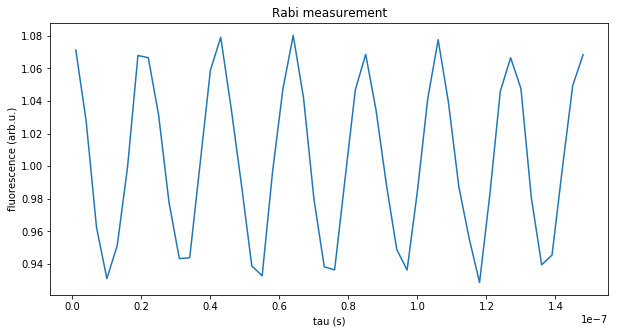

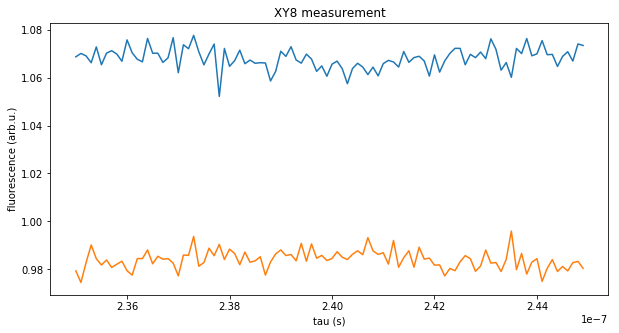

In [15]:
rabi_x, rabi_y = dc.get_data(rabi_file)
xy8_x, xy8_y1, xy8_y2 = dc.get_data(xy8_file)

if xy8_y1.mean() < xy8_y2.mean():
    xy8_y1, xy8_y2 = xy8_y2, xy8_y1

plt.plot(rabi_x, rabi_y)
plt.title('Rabi measurement')
plt.xlabel('tau (s)')
plt.ylabel('fluorescence (arb.u.)')
plt.show()

plt.plot(xy8_x, xy8_y1, xy8_x, xy8_y2)
plt.title('XY8 measurement')
plt.xlabel('tau (s)')
plt.ylabel('fluorescence (arb.u.)')
plt.show()

# Data analysis

### Perform fit on Rabi data and normalize XY8 data

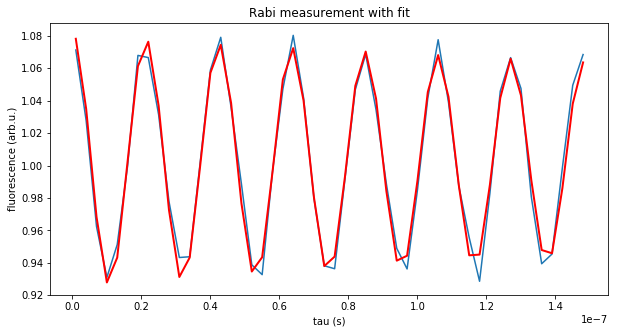

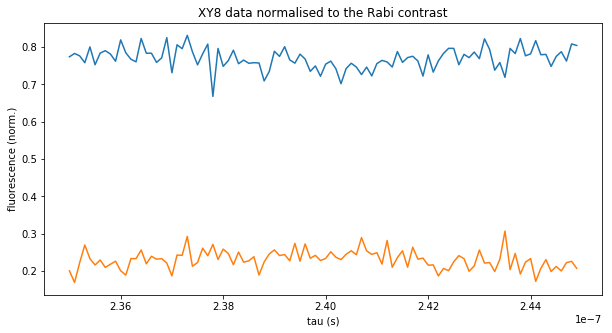

In [16]:
# Rabi fit (sine with exponential decay)
rabi_fit_result = fitting.make_sineexponentialdecay_fit(x_axis=rabi_x, data=rabi_y, estimator=fitting.estimate_sineexponentialdecay)
rabi_offset = rabi_fit_result.params['offset'].value
rabi_amplitude = rabi_fit_result.params['amplitude'].value
plt.plot(rabi_x, rabi_y)
plt.plot(rabi_x, rabi_fit_result.best_fit, linewidth=2., color='r')
plt.title('Rabi measurement with fit')
plt.xlabel('tau (s)')
plt.ylabel('fluorescence (arb.u.)')
plt.show()

# do XY8 normalisation and correct for values crossing the 0.5 line
level = ((xy8_y1+xy8_y2)/2).mean()
xy8_y1_norm = dc.do_normalisation(xy8_y1, rabi_amplitude, level)
xy8_y2_norm = dc.do_normalisation(xy8_y2, rabi_amplitude, level)
was_corrected = dc.correct_normalized_spectrum(xy8_y1_norm, xy8_y2_norm)
plt.plot(xy8_x, xy8_y1_norm, xy8_x, xy8_y2_norm)
plt.title('XY8 data normalised to the Rabi contrast')
plt.xlabel('tau (s)')
plt.ylabel('fluorescence (norm.)')
plt.show()

### Calculate and fit noise density spectrum

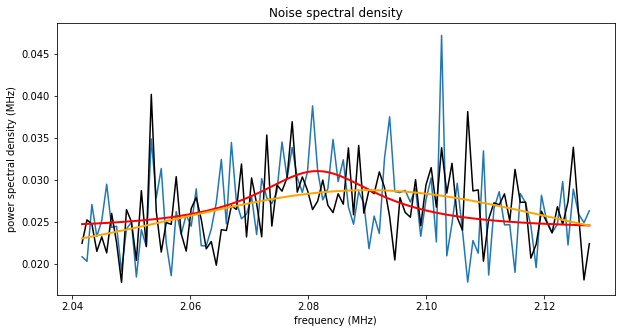

In [17]:
# Calculate noise density
nu = dc.nu_from_tau(xy8_x)
spectrum1 = dc.S_from_data(tau=xy8_x, y=xy8_y1_norm, N=8*N)
spectrum2 = dc.S_from_data(tau=xy8_x, y=1-xy8_y2_norm, N=8*N)

# perform Lorentzian fits
add_param = {'sigma': {'init_value': (np.abs(nu[-1]-nu[0]))/10, 'min': 0.0, 'max': np.abs(nu[-1]-nu[0])}}
spectrum1_fit_result = fitting.make_lorentzian_fit(x_axis=nu, data=spectrum1, estimator=fitting.estimate_lorentzian_peak, add_params=add_param)
spectrum2_fit_result = fitting.make_lorentzian_fit(x_axis=nu, data=spectrum2, estimator=fitting.estimate_lorentzian_peak, add_params=add_param)
plt.plot(nu/1e6, spectrum1/1e6)
plt.plot(nu/1e6, spectrum2/1e6, 'k')
plt.plot(nu/1e6, spectrum1_fit_result.best_fit/1e6, linewidth=2., color='r')
plt.plot(nu/1e6, spectrum2_fit_result.best_fit/1e6, linewidth=2., color='orange')
plt.title('Noise spectral density')
plt.xlabel('frequency (MHz)')
plt.ylabel('power spectral density (MHz)')
plt.show()

### Calculate NV depth based on the given spin density

In [18]:
# get the integral of the magnetic noise
spectrum1_area = np.pi * spectrum1_fit_result.params['amplitude'].value * spectrum1_fit_result.params['fwhm'].value/2
spectrum2_area = np.pi * spectrum2_fit_result.params['amplitude'].value * spectrum2_fit_result.params['fwhm'].value/2
# note that this areas are in Hz^2
B1 = (2*spectrum1_area/(gamma_e/(2*np.pi))**2)**0.5   # B1 is in Tesla now
B2 = (2*spectrum2_area/(gamma_e/(2*np.pi))**2)**0.5   # B2 is in Tesla now
print('B1 = {0} G'.format(B1*1e4))
print('B2 = {0} G'.format(B2*1e4))
# calculate the depth of the NV for given spin density:
depth1 = dc.calculate_depth_simple(mu_0, h, B1, gamma_p, rho)
depth2 = dc.calculate_depth_simple(mu_0, h, B2, gamma_p, rho)
mean_depth = (depth1+depth2)/2
print('depth1 = {0} nm'.format(depth1*1e9))
print('depth2 = {0} nm'.format(depth2*1e9))
print('mean depth = {0} nm'.format(mean_depth*1e9))
if was_corrected:
    print('\nWARNING: The normalized XY8 spectrum has been corrected since it contained points crossing the 0.5 mark.\n         Take this result with caution!')

B1 = 0.008487451948439955 G
B2 = 0.023525010696228678 G
depth1 = 15.281472966559578 nm
depth2 = 7.744562402358857 nm
mean depth = 11.513017684459218 nm


# (optional) Calculate spin density based on a given NV depth

In [ ]:
d1 = 3.7027003282742967e-9
d2 = 3.7027003282742967e-9
rho1 = dc.calculate_density_simple(mu_0, h, B1, gamma_p, d1)
rho2 = dc.calculate_density_simple(mu_0, h, B2, gamma_p, d2)
print('rho1 = {0}/nm³'.format(rho1/1e27))
print('rho2 = {0}/nm³'.format(rho2/1e27))